In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms.functional as TF
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split
from torchvision.io import read_image
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR

Wandb Connect

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cbba8c26be06372403a49f90af2a9cfd96ac069ef3f48fe40326c10290074496
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
TRAIN_IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/data/train"
TRAIN_MASK_DIR = "/content/drive/MyDrive/Colab Notebooks/data/train_gt"
TEST_IMG_TEST = "/content/drive/MyDrive/Colab Notebooks/data/test"
IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384
BATCHSIZE = 8
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_file_paths = sorted([os.path.join(TRAIN_IMG_DIR, path) for path in os.listdir(TRAIN_IMG_DIR)])
label_file_paths = sorted([os.path.join(TRAIN_MASK_DIR, path) for path in os.listdir(TRAIN_MASK_DIR)])
test_file_paths = sorted([os.path.join(TEST_IMG_TEST, path) for path in os.listdir(TEST_IMG_TEST)])

In [ ]:
# Num of instances 
num_train = len(train_file_paths)
num_label = len(label_file_paths)
num_test = len(test_file_paths)

print("Number of train images: ", num_train)
print("Number of train labels: ", num_label)
print("Number of test images: ", num_test)

Number of train images:  1000
Number of train labels:  1000
Number of test images:  200


In [ ]:
# check load data
print(train_file_paths[0:2])
print(label_file_paths[0:2])
print(test_file_paths[0:2])

['/content/drive/MyDrive/Colab Notebooks/data/train/0081835cf877e004e8bfb905b78a9139.jpeg', '/content/drive/MyDrive/Colab Notebooks/data/train/00d827b8bcf15050fb9af0ef92846b60.jpeg']
['/content/drive/MyDrive/Colab Notebooks/data/train_gt/0081835cf877e004e8bfb905b78a9139.jpeg', '/content/drive/MyDrive/Colab Notebooks/data/train_gt/00d827b8bcf15050fb9af0ef92846b60.jpeg']
['/content/drive/MyDrive/Colab Notebooks/data/test/019410b1fcf0625f608b4ce97629ab55.jpeg', '/content/drive/MyDrive/Colab Notebooks/data/test/02fa602bb3c7abacdbd7e6afd56ea7bc.jpeg']


Dataset and Dataloader

In [ ]:
train_paths, val_paths , train_label_paths, val_label_paths = train_test_split(train_file_paths, label_file_paths, test_size = 0.2, random_state = 73)
test_paths = test_file_paths

In [ ]:
print("Num of train:", len(train_paths))
print("Num of val:", len(val_paths))
print("Num of test:", len(test_paths))

Num of train: 800
Num of val: 200
Num of test: 200


In [ ]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH, cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])
val_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH)
])

In [ ]:
def labeled2mask(label_image, threshold = 50):
    """
    label_image(h,w, 3) (Pillow Image) => torch: mask_image(c,h)
    labeled image to mask image 
    """
    labeled_image_ar = Image.open(label_image)
    labeled_image_ar = np.array(labeled_image_ar) # since it is immutable
    labeled_image_ar[:, : , 2]  = labeled_image_ar[:, : , 2] + threshold
    return np.argmax(labeled_image_ar, 2)

Dataset and Dataloader

In [ ]:
class IGHDataSet(Dataset):
    def __init__(self, transform = None, is_train = True, mean_trans = [0.485, 0.456, 0.406], std_trans = [0.229, 0.224, 0.225], debug = False):
        
        self.is_train = is_train
        self.transform = transform
        self.mean_trans = mean_trans
        self.std_trans = std_trans
        
        if self.is_train:
            if not debug:
                self.img_paths = train_paths
                self.label_paths = train_label_paths
            else:
                self.img_paths = train_paths[:200]
                self.label_paths = train_label_paths[:200]
        else:
            if not debug:
                self.img_paths = val_paths
                self.label_paths = val_label_paths
            else:
                self.img_paths = val_paths[:50]
                self.label_paths = val_label_paths[:50]
    
        
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = np.array(img)
        # mask = labeled2mask(self.label_paths[idx])
        mask = Image.open(self.label_paths[idx])
        mask = np.array(mask)
        mask[:, :, 2] = mask[:, :, 2] + 50
        if self.transform is not None:
            data = self.transform(image = img, mask = mask)
        else:
            img = Image.fromarray(img)
        img = data['image']; mask = data['mask']
        t = T.Compose([T.ToTensor(), T.Normalize([0.0,0.0,0.0],[1.0,1.0,1.0])])
        img = t(img)
        mask = t(mask)
        mask = torch.argmax(mask, dim = 0)
        # mask = torch.from_numpy(mask).long()
        return img, mask # HWC
    
    def __len__(self):
        return len(self.img_paths)
        

In [ ]:
DEBUG_MODE = False
train_set = IGHDataSet(train_transform, is_train = True, debug = DEBUG_MODE )
val_set = IGHDataSet(val_transform, is_train = False)

In [ ]:
# Dataloader
train_loader = DataLoader(train_set, batch_size = BATCHSIZE, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_set, batch_size = BATCHSIZE, shuffle = False, num_workers = 2)  

In [ ]:
img , mask = next(iter(train_loader))
mask1 = torch.zeros(mask.shape)
mask = torch.argmax(mask, dim = 1)

import smp

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-o0bojo4q
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-o0bojo4q
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 8523324c116dcf7be6bddb73bf4eb1779ef6e611
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.9 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [ ]:
ENCODER_NAME = "resnet34"
ENCODER_WEIGHT = "imagenet"
NUM_CHANNELS = 3
CLASSES = 3

In [ ]:
model = smp.Unet(encoder_name = ENCODER_NAME,
                 encoder_weights= ENCODER_WEIGHT,
                 in_channels = NUM_CHANNELS, 
                 classes = CLASSES)
params = smp.encoders.get_preprocessing_params(ENCODER_NAME)
loss =  smp.losses.DiceLoss(mode = 'multiclass',classes = 3, from_logits=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=30,  gamma=0.2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
DEVICE

device(type='cuda')

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/model_pretrained7.pth')

In [ ]:
class Train:
  def __init__(self, model, params, train_loader, val_loader, loss, optimizer, scheduler, device):
    self.model = model
    self.params = params
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.loss = loss
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.device = device

    # preprocessing parameteres for image
    # self.register_buffer("std", torch.tensor(self.params["std"]).view(1, 3, 1, 1))
    # self.register_buffer("mean", torch.tensor(self.params["mean"]).view(1, 3, 1, 1))

  def forward(self, image):
    image = (image - self.mean) / self.std
    mask = self.model(image)
    return mask

  def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

  def Iou_Score(self, output, mask):
       output = torch.argmax(output, dim = 1)
       tp, fp, fn, tn = smp.metrics.get_stats(output.long(), mask.long(), mode="multiclass",num_classes=3)
       per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
       return per_image_iou

  def fit(self, num_epochs):
    wandb.init(project="Polyp_pretrained")
    lrs = []
    wandb.init()
    self.model.to(self.device)

    for e in range(num_epochs):
      wandb.log({"Epoch": e + 1})
      self.model.train()
      training_loss = 0.0
      val_loss = 0.0
      iou_score = 0.0
      val_iou_score = 0.0
      for i, (image, mask) in enumerate(self.train_loader):
        image = image.to(self.device)
        mask = mask.to(self.device)
        output = self.model(image)
        loss = self.loss(output, mask)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() 
        training_loss += loss.item()
        iou_score += self.Iou_Score(output, mask)
      wandb.log({"Train Dice Loss": training_loss/len(train_loader),
                 "IoU score": iou_score/len(train_loader)})
          #validation loop
      with torch.no_grad():
          for i, (image, mask) in enumerate(self.val_loader):
              image = image.to(DEVICE)
              mask = mask.to(DEVICE)
              output = self.model(image)
              #loss
              loss = self.loss(output, mask)
              #evaluation metrics
              val_loss += loss.item()
              #evaluate iou_score
              val_iou_score += self.Iou_Score(output, mask)
          wandb.log({"Val Dice Loss": val_loss/len(val_loader),
                 "Val IoU score": val_iou_score/ len(val_loader)})

In [ ]:
trainer = Train(model, params, train_loader, val_loader, loss, optimizer, scheduler, DEVICE)

In [ ]:
for i in range(8, 10):
  trainer.fit(20)
  torch.save(model, '/content/drive/MyDrive/Colab Notebooks/model_pretrained{}.pth'.format(i))

wandb: Currently logged in as: thanh-bv. Use `wandb login --relogin` to force relogin


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
IoU score,▂▂▃▄▅▆▃▆▃▃▄▇▄▅▃▄█▅▁▅
Train Dice Loss,▅▇▆▅▄▅▆▃▄▄▄▁█▄▇▄▁▄█▄
Val Dice Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val IoU score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,20
IoU score,0.97941
Train Dice Loss,0.15884
Val Dice Loss,0.28159
Val IoU score,0.96095


In [ ]:
pre_model = torch.load('/content/drive/MyDrive/Colab Notebooks/model_pretrained7.pth')
# /content/drive/MyDrive/Colab Notebooks/model_pretrained7.pth

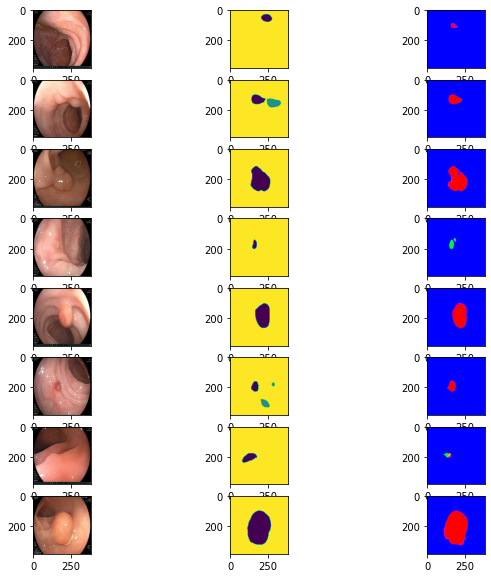

In [ ]:
image1, mask1 = next(iter(val_loader))
image1 = image1.to(DEVICE)
mask1 = mask1.to(DEVICE)
output1 = pre_model(image1)
image1 = image1.cpu().numpy()
mask1 = mask1.cpu().numpy()
output1= output1.cpu().detach().numpy()
image1 = image1.transpose(0,2,3,1)
output1= output1.transpose(0,2,3,1)
fig, axs = plt.subplots(8,3, figsize=(10, 10))
for i in range(8):
  axs[i, 0].imshow(image1[i])
  axs[i, 1].imshow(mask1[i])
  axs[i, 2].imshow(output1[i])